# APIM ❤️ AI Foundry

## AI Foundry Deepseek lab
![flow](../../images/ai-foundry-deepseek.gif)

Playground to try the [Deepseek R1 model](https://azure.microsoft.com/en-us/blog/deepseek-r1-is-now-available-on-azure-ai-foundry-and-github/) via the AI Model Inference from [Azure AI Foundry](https://azure.microsoft.com/en-us/products/ai-foundry). This lab uses the [Azure AI Model Inference API](https://learn.microsoft.com/en-us/azure/ai-foundry/model-inference/how-to/inference?tabs=python) and two APIM LLM policies: [llm-token-limit](https://learn.microsoft.com/en-us/azure/api-management/llm-token-limit-policy) and [llm-emit-token-metric](https://learn.microsoft.com/en-us/azure/api-management/llm-emit-token-metric-policy).

[View policy configuration](policy.xml)

### Result

![result](result.png)

### Prerequisites
- [Python 3.12 or later version](https://www.python.org/) installed
- [Pandas Library](https://pandas.pydata.org/) and matplotlib installed
- [VS Code](https://code.visualstudio.com/) installed with the [Jupyter notebook extension](https://marketplace.visualstudio.com/items?itemName=ms-toolsai.jupyter) enabled
- [Azure CLI](https://learn.microsoft.com/cli/azure/install-azure-cli) installed
- [An Azure Subscription](https://azure.microsoft.com/free/) with Contributor permissions
- [Sign in to Azure with Azure CLI](https://learn.microsoft.com/cli/azure/authenticate-azure-cli-interactively)

<a id='0'></a>
### 0️⃣ Initialize notebook variables

- Resources will be suffixed by a unique string based on your subscription id.
- Adjust the location parameters according your preferences and on the [product availability by Azure region.](https://azure.microsoft.com/explore/global-infrastructure/products-by-region/?cdn=disable&products=cognitive-services,api-management) 
- Adjust the OpenAI model and version according the [availability by region.](https://learn.microsoft.com/azure/ai-services/openai/concepts/models) 

In [1]:
import os, sys, json
sys.path.insert(1, '../../shared')  # add the shared directory to the Python path
import utils

deployment_name = os.path.basename(os.path.dirname(globals()['__vsc_ipynb_file__']))
resource_group_name = f"techo-{deployment_name}-v1" # change the name to match your naming convention
resource_group_location = "eastus2" # all the resources will be deployed in this location

apim_sku = 'Standard'
apim_subscriptions_config = [{"name": "subscription1", "displayName": "Subscription 1"}, 
                             {"name": "subscription2", "displayName": "Subscription 2"}, 
                             {"name": "subscription3", "displayName": "Subscription 3"}]

# https://learn.microsoft.com/en-us/azure/ai-foundry/model-inference/concepts/models
models_config = [{"name": "DeepSeek-R1", "publisher": "DeepSeek", "version": "1", "sku": "GlobalStandard", "capacity": 1},
                 {"name": "Phi-4", "publisher": "Microsoft", "version": "3", "sku": "GlobalStandard", "capacity": 1}]

utils.print_ok('Notebook initialized')

✅ Notebook initialized ⌚ 21:57:23.064648 


<a id='1'></a>
### 1️⃣ Verify the Azure CLI and the connected Azure subscription

The following commands ensure that you have the latest version of the Azure CLI and that the Azure CLI is connected to your Azure subscription.

In [2]:
output = utils.run("az account show", "Retrieved az account", "Failed to get the current az account")

if output.success and output.json_data:
    current_user = output.json_data['user']['name']
    tenant_id = output.json_data['tenantId']
    subscription_id = output.json_data['id']

    utils.print_info(f"Current user: {current_user}")
    utils.print_info(f"Tenant ID: {tenant_id}")
    utils.print_info(f"Subscription ID: {subscription_id}")

⚙️ Running: az account show 
✅ Retrieved az account ⌚ 21:57:27.840501 :1s]
👉🏽 Current user: inbox@massimocrippa.com
👉🏽 Tenant ID: 1de23963-6823-4ea6-9ac4-4cf69c102307
👉🏽 Subscription ID: b717ac47-f31b-41f9-adc2-579932e7e02e


<a id='2'></a>
### 2️⃣ Create deployment using 🦾 Bicep

This lab uses [Bicep](https://learn.microsoft.com/azure/azure-resource-manager/bicep/overview?tabs=bicep) to declarative define all the resources that will be deployed in the specified resource group. Change the parameters or the [main.bicep](main.bicep) directly to try different configurations. 

In [6]:
# Create the resource group if doesn't exist
utils.create_resource_group(resource_group_name, resource_group_location)

# Define the Bicep parameters
bicep_parameters = {
    "$schema": "https://schema.management.azure.com/schemas/2019-04-01/deploymentParameters.json#",
    "contentVersion": "1.0.0.0",
    "parameters": {
        "apimSku": { "value": apim_sku },
        "apimSubscriptionsConfig": { "value": apim_subscriptions_config },
        "modelsConfig": { "value": models_config }
    }
}

# Write the parameters to the params.json file
with open('params.json', 'w') as bicep_parameters_file:
    bicep_parameters_file.write(json.dumps(bicep_parameters))

# Run the deployment
output = utils.run(f"az deployment group create --name {deployment_name} --resource-group {resource_group_name} --template-file main.bicep --parameters params.json",
    f"Deployment '{deployment_name}' succeeded", f"Deployment '{deployment_name}' failed")

⚙️ Running: az group show --name techo-ai-foundry-deepseek-v1 
👉🏽 Using existing resource group 'techo-ai-foundry-deepseek-v1'
⚙️ Running: az deployment group create --name ai-foundry-deepseek --resource-group techo-ai-foundry-deepseek-v1 --template-file main.bicep --parameters params.json 
✅ Deployment 'ai-foundry-deepseek' succeeded ⌚ 18:03:19.988882 :51s]


<a id='3'></a>
### 3️⃣ Get the deployment outputs

Retrieve the required outputs from the Bicep deployment.

In [3]:
# Obtain all of the outputs from the deployment
output = utils.run(f"az deployment group show --name {deployment_name} -g {resource_group_name}", f"Retrieved deployment: {deployment_name}", f"Failed to retrieve deployment: {deployment_name}")

if output.success and output.json_data:
    app_insights_name = utils.get_deployment_output(output, 'applicationInsightsName', 'Application Insights Name')    
    apim_resource_gateway_url = utils.get_deployment_output(output, 'apimResourceGatewayURL', 'APIM API Gateway URL')
    apim_subscriptions = json.loads(utils.get_deployment_output(output, 'apimSubscriptions').replace("\'", "\""))
    for subscription in apim_subscriptions:
        subscription_name = subscription['name']
        subscription_key = subscription['key']
        utils.print_info(f"Subscription Name: {subscription_name}")
        utils.print_info(f"Subscription Key: ****{subscription_key[-4:]}")


⚙️ Running: az deployment group show --name ai-foundry-deepseek -g techo-ai-foundry-deepseek-v1 
✅ Retrieved deployment: ai-foundry-deepseek ⌚ 21:57:32.993592 :2s]
👉🏽 Application Insights Name: insights-s2zftpqjqjwzw
👉🏽 APIM API Gateway URL: https://apim-s2zftpqjqjwzw.azure-api.net
👉🏽 Subscription Name: subscription1
👉🏽 Subscription Key: ****2bc6
👉🏽 Subscription Name: subscription2
👉🏽 Subscription Key: ****7dcc
👉🏽 Subscription Name: subscription3
👉🏽 Subscription Key: ****b07f


<a id='sdk'></a>
### 🧪 Test the API using the Inference SDK


In [ ]:
from azure.ai.inference import ChatCompletionsClient
from azure.ai.inference.models import SystemMessage, UserMessage
from azure.core.credentials import AzureKeyCredential

client = ChatCompletionsClient(
    endpoint=f"{apim_resource_gateway_url}/models",
    credential=AzureKeyCredential(apim_subscriptions[0]['key']),
)

response = client.complete(
    messages=[
        SystemMessage(content="You are a sarcastic, unhelpful assistant."),
        UserMessage(content="Can you tell me what is the #1 Conference for IT & Microsoft professionals in Belgium, please?")
    ],
    max_tokens=2048,
    model=models_config[0]['name']
)

print(response.choices[0].message.content)

<a id='ratelimit'></a>
### 🧪 Test the token rate limit


In [ ]:
import requests

url = apim_resource_gateway_url + "/models/chat/completions?api-version=2024-05-01-preview"

utils.print_info(f"URL: {url}")
api_runs = []
for i in range(10):
    messages={"messages":[
            {"role": "system", "content": "You are a sarcastic, unhelpful assistant."},
            {"role": "user", "content": "Can you tell me what is the #1 Conference for IT & Microsoft professionals in Belgium, please?"}
        ],
        "model": models_config[0]['name']
    }
    response = requests.post(url, headers={'api-key': apim_subscriptions[0]['key']}, json=messages)
    if (response.status_code == 200):
        data = json.loads(response.text)
        total_tokens = data.get("usage").get("total_tokens")
        print("▶️ Run: ", i+1, "status code: ", response.status_code, "✅", " tokens: ", total_tokens)
        print("💬 ", data.get("choices")[0].get("message").get("content"))
    else:
        print("▶️ Run: ", i+1, "status code: ", response.status_code, "⛔")
        print(response.text)
        total_tokens = 0
    api_runs.append((total_tokens, response.status_code))


<a id='plot'></a>
### 🔍 Analyze Token Rate limiting results

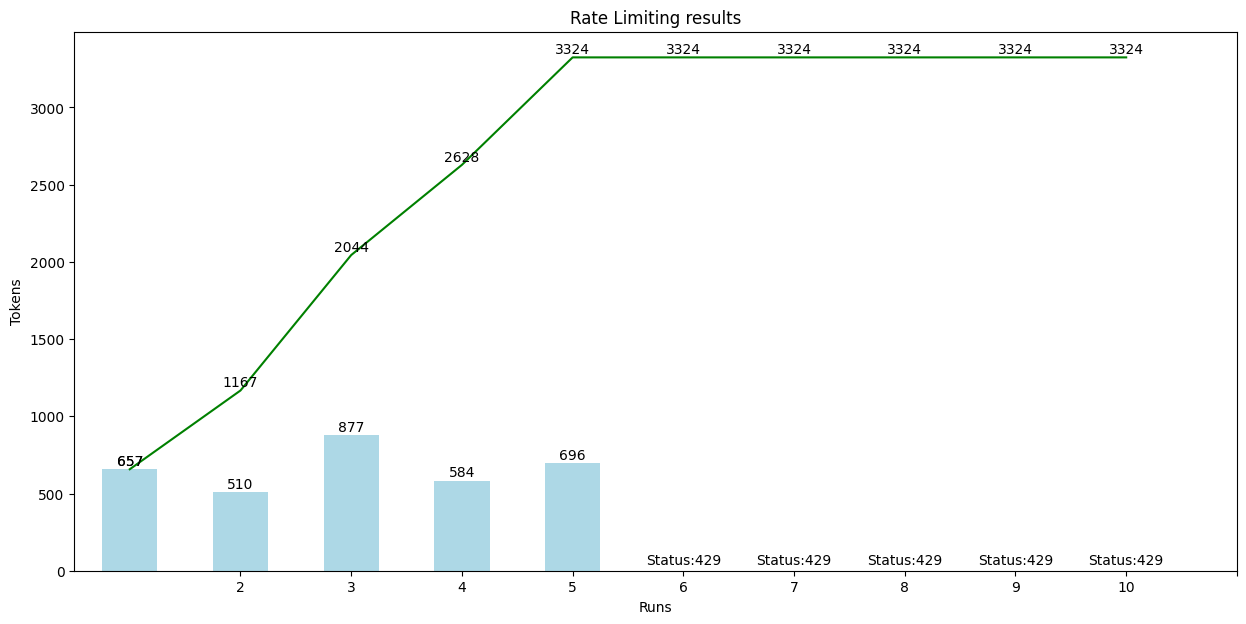

In [12]:
# plot the results
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['figure.figsize'] = [15, 7]
df = pd.DataFrame(api_runs, columns=['Tokens', 'Status Code'])
df['Run'] = range(1, len(df) + 1)
colors = ['red' if str(code).startswith('5') else 'yellow' if str(code).startswith('4') else 'lightblue' for code in df['Status Code']]
ax = df.plot(kind='bar', x='Run', y='Tokens', color=colors, legend=False)
plt.title('Rate Limiting results')
plt.xlabel('Runs')
plt.ylabel('Tokens')
plt.xticks(df['Run'], rotation=0)
for i, val in enumerate(df['Status Code']):
    ax.text(i, 20, '' if int(val) == 200 else 'Status:429', ha='center', va='bottom')
for i, val in enumerate(df['Tokens']):
    ax.text(i, df['Tokens'][i] + 5, '' if int(val) == 0 else val, ha='center', va='bottom')
accumulated_tokens = df['Tokens'].cumsum()
ax.plot(df['Run']-1, accumulated_tokens, color='green', label='Accumulated Tokens')
for i, val in enumerate(accumulated_tokens):
    ax.text(i, val + 6, str(int(val)), ha='center', va='bottom', label='Accumulated Tokens')
plt.show()

<a id='ratelimit'></a>
### 🧪 Test the emit token metric with the configured subscriptions


In [ ]:
import random
from azure.ai.inference import ChatCompletionsClient
from azure.ai.inference.models import SystemMessage, UserMessage
from azure.core.credentials import AzureKeyCredential

for i in range(10):
    client = ChatCompletionsClient(
        endpoint=f"{apim_resource_gateway_url}/models",
        credential=AzureKeyCredential(random.choice(apim_subscriptions)['key']),
    )
    response = client.complete(
        messages=[
            SystemMessage(content="You are a sarcastic, unhelpful assistant."),
            UserMessage(content="Can you tell me the time, please?")
        ],
        max_tokens=2048,
        model=models_config[0]['name']
    )
    print("▶️ Run: ", i+1, "🗨️\n", response.choices[0].message.content)

<a id='kql'></a>
### 🔍 Analyze Application Insights custom metrics with a KQL query

With this query you can get the custom metrics that were emitted by Azure APIM. Note that it may take a few minutes for data to become available.

In [10]:
import pandas as pd

query = "\"" + "customMetrics \
| where name == 'Total Tokens' \
| where timestamp >= ago(1h) \
| extend parsedCustomDimensions = parse_json(customDimensions) \
| extend apimSubscription = tostring(parsedCustomDimensions.['Subscription ID']) \
| summarize TotalValue = sum(value) by apimSubscription, bin(timestamp, 1m) \
| order by timestamp asc" + "\""

output = utils.run(f"az monitor app-insights query --app {app_insights_name} -g {resource_group_name} --analytics-query {query}",
    f"App Insights query succeeded", f"App Insights query  failed")

table = output.json_data['tables'][0]
df = pd.DataFrame(table.get("rows"), columns = [col.get("name") for col in table.get('columns')])
df['timestamp'] = pd.to_datetime(df['timestamp']).dt.strftime('%H:%M')

df


⚙️ Running: az monitor app-insights query --app insights-s2zftpqjqjwzw -g techo-ai-foundry-deepseek-v1 --analytics-query "customMetrics | where name == 'Total Tokens' | where timestamp >= ago(1h) | extend parsedCustomDimensions = parse_json(customDimensions) | extend apimSubscription = tostring(parsedCustomDimensions.['Subscription ID']) | summarize TotalValue = sum(value) by apimSubscription, bin(timestamp, 1m) | order by timestamp asc" 
✅ App Insights query succeeded ⌚ 22:38:39.858079 :8s]


,apimSubscription,timestamp,TotalValue
0,subscription1,19:58,2076
1,subscription1,19:59,1877
2,subscription1,20:02,1051
3,subscription1,20:03,2340
4,subscription1,20:04,2337
5,subscription1,20:05,949
6,subscription1,20:06,3033
7,subscription2,20:07,1444
8,subscription3,20:07,689
9,subscription1,20:07,938


<a id='plot'></a>
### 🔍 Plot the custom metrics results

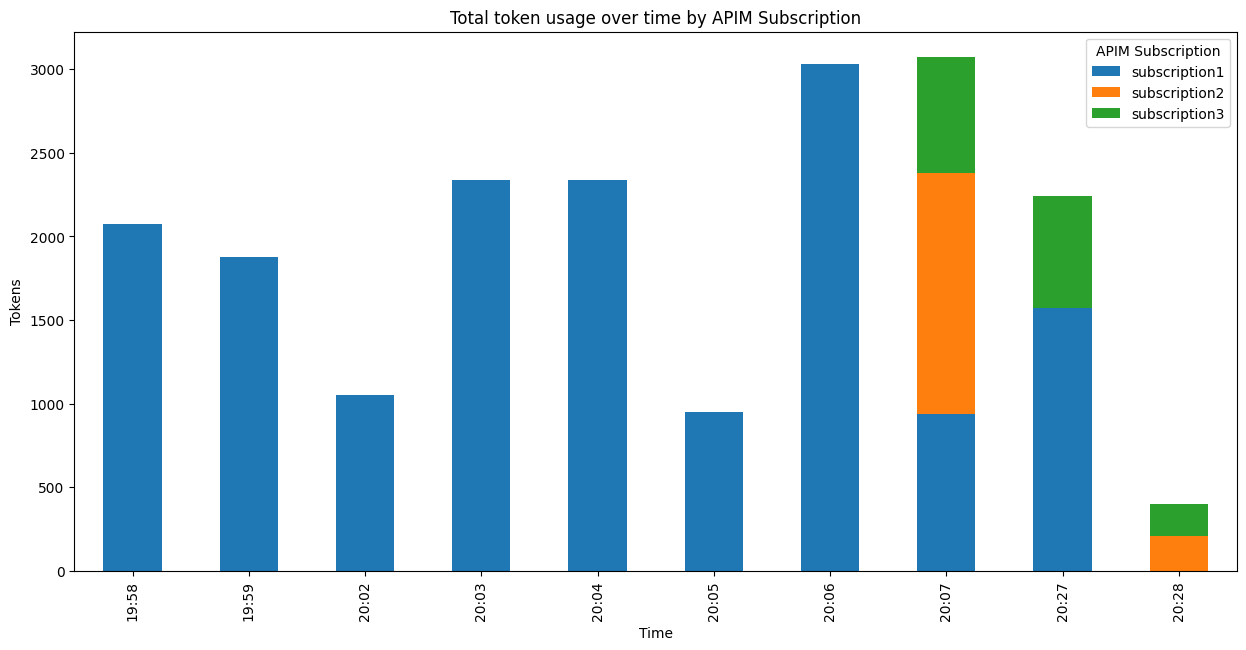

In [11]:
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['figure.figsize'] = [15, 7]
if df.empty:
    print("No data to plot")
else:
    df_pivot = df.pivot(index='timestamp', columns='apimSubscription', values='TotalValue')
    ax = df_pivot.plot(kind='bar', stacked=True)
    plt.title('Total token usage over time by APIM Subscription')
    plt.xlabel('Time')
    plt.ylabel('Tokens')
    plt.legend(title='APIM Subscription')
    plt.show()

<a id='portal'></a>
### 🔍 See the metrics on the Azure Portal

Open the Application Insights resource, navigate to the Metrics blade, then select the defined namespace (llm). Choose the metric "Total Tokens" with a Sum aggregation. Then, apply splitting by 'Subscription Id' to view values for each dimension.


<a id='clean'></a>
### 🗑️ Clean up resources

When you're finished with the lab, you should remove all your deployed resources from Azure to avoid extra charges and keep your Azure subscription uncluttered.
Use the [clean-up-resources notebook](clean-up-resources.ipynb) for that.